### Malware Analysis Using Neural Networks

In this implementation, we will be leveraging the Nvidia Malconv Architecture [1] to build the model for predicting and classifying the Malware.  
Below is the reference architecture and our implementation process:

<img src="Malconv-arc.png" alt="Malconv Architecture" height="300" width="500"/>

In [1]:
#Importing required libraries
import re
import collections
from os import listdir
from os.path import isfile, join
import binascii
import numpy as np
import pandas as pd
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import datetime

Using TensorFlow backend.


In [2]:
print (datetime.datetime.now())

2019-12-01 19:30:44.594837


### Data Engineering
 
**Pre-requistes:**
1. Place the train_dataset and test_dataset in two directories.  
2. Run the shell script which will split the train dataset into train and test for modeling.  

We will clean the byte sequences for any unknown characters and do the embedding by converting the input to a numerical format - each byte into an eight dimensional vector. 

In [3]:
#Input files Paths
TrainLabelspath = "/mnt/disks/MLProject/data/r_TrainLabels.csv"
TestLabelspath = "/mnt/disks/MLProject/data/r_Testlabels.csv" 

TraindatasetPath = "/mnt/disks/MLProject/data/r_train_dataset/"
TestdatasetPath = "/mnt/disks/MLProject/data/r_test_dataset/"

In [4]:
#Method for Cleaning the bytes
def cleanByteSequence(byteSequence):
    dataStr = str(byteSequence)
    dataStr = dataStr[2:]
    dataStr = dataStr.replace("\\r\\n", " ")
    dataStr2 = re.sub(r'\b\w{8}\b','',dataStr)
    dataStr3 = re.sub(r'\s+'," ", dataStr2)
    return dataStr3

def readFile(filePath):
    with open(filePath, "rb") as binary_file:
        data = binary_file.read()
        return data

#Method of Embedding bytes
def embedByte(hex_string):
    scale = 16
    num_of_bits = 8
    if(hex_string[0] =="?"):
        hex_string = "00"
    if(hex_string[1] == "?"):
        hex_string[1] = "00"
        
    binary_string = bin(int(hex_string, scale)) [2:].zfill(num_of_bits)
    vec = np.zeros(8)
    for i in range(8):
        if(binary_string[i]=="1"):
            vec[i]=float(1)/16
        else:
            vec[i]=-float(1)/16
            
    return vec

In [5]:
#Embedding - Converting the input to a numerical format.
#Embed each byte into a eight dimensional vector.
# 1 -> 1/16 and 0 -> -1/16
hex_string = "A6"
scale = 16
num_of_bits = 8
binary_string = bin(int(hex_string, scale)) [2:].zfill(num_of_bits)
print(binary_string)
print(embedByte(hex_string))

10100110
[ 0.0625 -0.0625  0.0625 -0.0625 -0.0625  0.0625  0.0625 -0.0625]


In [6]:
print(datetime.datetime.now())

2019-12-01 19:30:44.675101


In [7]:
samples = [f for f in listdir(TraindatasetPath) if isfile(join(TraindatasetPath, f))]
data = pd.read_csv(TrainLabelspath)
targetDict = data.set_index('Id').T.to_dict('records')[0]

In [8]:
#Reading Samples
max_size = 30000      #Number of bytes to read per sample
num_samples = len(samples)
Train_X = np.zeros((num_samples, 8, max_size))
Train_Y = np.zeros(num_samples)
fileNum = 0
for file in samples:
    filePath = join(TraindatasetPath, file)
    sampleByteSequence = readFile(filePath)
    #print(fileNum)
    cleanedByteSequence = cleanByteSequence(sampleByteSequence)
    splitByteSequence = cleanedByteSequence.strip().split(" ")
    Train_Y[fileNum] = targetDict[file.split(".")[0]]       #Stores the labels
    
    for i in range(min(max_size, len(splitByteSequence))):
        Train_X[fileNum,:,i] = embedByte(splitByteSequence[i]) #All embeded data 
    fileNum += 1

In [9]:
print(datetime.datetime.now())

2019-12-01 20:53:18.627009


In [10]:
#Convert lables to categorical form
Train_Y_one_hot = to_categorical(Train_Y-1)
print(Train_Y_one_hot)
print(Train_Y_one_hot.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(6520, 9)


### Building the Model
Using Keras functional API, we will take two convolutions - conv1 and conv2 and then activate one of the convolutions, say conv2, sigmoid. We then multiply the Activated convolution and  non activated convolution and activate the final result - relu.

In [11]:
num_classes = 9
from keras import optimizers
from keras import Input
from keras.layers import Conv1D
from keras.layers import Activation 
from keras.layers import multiply
from keras.layers import GlobalMaxPool1D
from keras.layers import Dense
from keras import Model

In [12]:
opt = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True) #Model parameters

In [13]:
inputs = Input(shape=(8,max_size)) #Inputs for Conv

In [14]:
conv1 = Conv1D(kernel_size=(128), filters=32, strides=(128), padding='same')(inputs)

In [15]:
conv2 = Conv1D(kernel_size=(128), filters=32, strides=(128), padding='same')(inputs)

In [16]:
a = Activation('sigmoid', name='sigmoid')(conv2)  #Activation

In [17]:
mul = multiply([conv1, a]) #Multiplying Activated one and Non-Activated one.

In [18]:
a = Activation('relu', name='relu')(mul) #Activating the result - mul

In [19]:
p = GlobalMaxPool1D()(a)

In [20]:
d = Dense(16)(p)

In [21]:
predictions = Dense(num_classes, activation = 'sigmoid') (d)

In [22]:
model = Model(inputs=inputs, outputs=predictions)

In [23]:
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])

##### Model summary:

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 8, 30000)     0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 1, 32)        122880032   input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 32)        122880032   input_1[0][0]                    
__________________________________________________________________________________________________
sigmoid (Activation)            (None, 1, 32)        0           conv1d_2[0][0]                   
____________________________________________________________________________________________

### Training the Model with Train Dataset
Subset of given Train dataset

In [25]:
#Dividing the dataset into multiple batches
batch_size = 16   
num_batches = int(num_samples/batch_size)

for batch_num in range(num_batches):
    batch = Train_X[batch_num * batch_size:(batch_num+1)*batch_size]
    model.train_on_batch(batch, Train_Y_one_hot[batch_num * batch_size:(batch_num+1)*batch_size])

In [26]:
#Model predict on Train dataset
pred = model.predict(Train_X)

In [27]:
pred

array([[1.8636015e-01, 3.4818327e-01, 1.4707336e-01, ..., 1.3202521e-01,
        1.9714361e-01, 3.8580161e-01],
       [3.5007238e-02, 7.8141689e-05, 2.8371811e-05, ..., 1.6987324e-06,
        3.8442016e-04, 9.7614527e-04],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        7.8418374e-01, 4.6789646e-06],
       ...,
       [1.3202429e-04, 3.4987926e-04, 6.3002110e-05, ..., 7.7486038e-07,
        2.7793646e-04, 8.3729100e-01],
       [1.2931228e-04, 6.0163766e-01, 0.0000000e+00, ..., 2.3841858e-07,
        4.7683716e-07, 3.0022860e-04],
       [7.8626871e-03, 8.9940429e-04, 1.4007092e-06, ..., 2.4139881e-06,
        1.4075637e-04, 5.2276254e-04]], dtype=float32)

In [28]:
pred_label = []
for row in pred:
    pred_label.append(np.argmax(row))

In [29]:
Train_Y_np = np.asarray(Train_Y-1)
print(Train_Y_np)

[5. 0. 7. ... 8. 1. 1.]


In [30]:
#pred_label  #To see the predicted labels. Commented for readability and debugging

In [32]:
#Train Model Accuracy
str(sum(pred_label == Train_Y_np)/len(Train_Y_np)*100)+"%"

'97.62269938650306%'

(array([ 912., 1497., 1760.,  278.,    0.,    6.,  455.,  227.,  795.,
         590.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

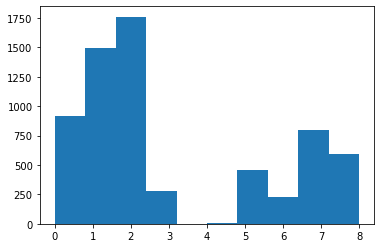

In [31]:
#Plotting a histogram to show the label distribution
plt.hist(pred_label)

In [33]:
print(datetime.datetime.now())

2019-12-01 21:19:11.688610


### Testing the Model
Running the model on our Test dataset (which is a split from "given" Train dataset).

In [34]:
testSamples = [f for f in listdir(TestdatasetPath) if isfile(join(TestdatasetPath, f))]
num_samples = len(testSamples)
data_test = pd.read_csv(TestLabelspath)
targetDict_test = data_test.set_index('Id').T.to_dict('records')[0]

In [35]:
Test_X = np.zeros((num_samples, 8, max_size))
Test_Y = np.zeros(num_samples)
fileNum = 0

for file in testSamples:
    filePath = join(TestdatasetPath, file)
    sampleByteSequence = readFile(filePath)
    #print(fileNum)
    cleanedByteSequence = cleanByteSequence(sampleByteSequence)
    splitByteSequence = cleanedByteSequence.strip().split(" ")
    Test_Y[fileNum] = targetDict_test[file.split(".")[0]]
    for i in range(min(max_size, len(splitByteSequence))):
        Test_X[fileNum,:,i] = embedByte(splitByteSequence[i])
    fileNum += 1

In [36]:
#Predictions on Test dataset using the built model
Test_Y_np = np.asarray(Test_Y-1)
Test_Y_pred = model.predict(Test_X)
Test_Y_pred_label = []
for row in Test_Y_pred:
    Test_Y_pred_label.append(np.argmax(row))

In [37]:
#Test Model Accuracy
str(sum(Test_Y_pred_label == Test_Y_np)/len(Test_Y_np)*100)+"%"

'89.44342226310947%'

(array([ 645.,  978., 1179.,  132.,    0.,    0.,  282.,  142.,  497.,
         493.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

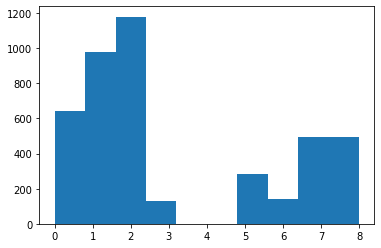

In [38]:
#Plotting a histogram to show the label distribution
plt.hist(Test_Y_pred_label)

In [39]:
print(datetime.datetime.now())

2019-12-01 22:16:15.829232


### Predict on Test Dataset
Running the model to predict the classification on the "given" Test dataset, which don't have labels.  
The dataset is divided into two to optimize the memory and it is nearly same code with different test files.

In [40]:
print(datetime.datetime.now())

2019-12-01 22:16:15.834289


In [41]:
#Original Test Dataset and dummy Labels file.
o_TestLabelspath = "/mnt/disks/MLProject/data/testLabels.csv" 
o_TestdatasetPath = "/mnt/disks/MLProject/data/test_dataset"

testSamples = [f for f in listdir(o_TestdatasetPath) if isfile(join(o_TestdatasetPath, f))]
#Readiing the first half of the dataset
testSamples = testSamples[:5000] 

num_samples = len(testSamples)
data_test = pd.read_csv(o_TestLabelspath)
targetDict_test_o = data_test.set_index('Id').T.to_dict('records')[0]

Testo_X = np.zeros((num_samples, 8, max_size))
Testo_Y = np.zeros(num_samples)
fileNum = 0

for file in testSamples:
    filePath = join(o_TestdatasetPath, file)
    sampleByteSequence = readFile(filePath)
    cleanedByteSequence = cleanByteSequence(sampleByteSequence)
    splitByteSequence = cleanedByteSequence.strip().split(" ")
    Testo_Y[fileNum] = targetDict_test_o[file.split(".")[0]]
    for i in range(min(max_size, len(splitByteSequence))):
        Testo_X[fileNum,:,i] = embedByte(splitByteSequence[i])
    fileNum += 1

Testo_Y_np = np.asarray(Testo_Y-1)
Testo_Y_pred = model.predict(Testo_X)
Testo_Y_pred_label = []

for row in Testo_Y_pred:
    Testo_Y_pred_label.append(np.argmax(row))
  


In [42]:
print(datetime.datetime.now())

2019-12-01 23:21:47.423102


In [43]:
o_TestLabelspath = "/mnt/disks/MLProject/data/testLabels.csv" 
o_TestdatasetPath = "/mnt/disks/MLProject/data/test_dataset"

testSamples = [f for f in listdir(o_TestdatasetPath) if isfile(join(o_TestdatasetPath, f))]
#Reading the second half of the dataset
testSamples = testSamples[5000:]

num_samples = len(testSamples)
data_test = pd.read_csv(o_TestLabelspath)
targetDict_test_o = data_test.set_index('Id').T.to_dict('records')[0]

Testo_X = np.zeros((num_samples, 8, max_size))
Testo_Y = np.zeros(num_samples)
fileNum = 0

for file in testSamples:
    filePath = join(o_TestdatasetPath, file)
    sampleByteSequence = readFile(filePath)
    cleanedByteSequence = cleanByteSequence(sampleByteSequence)
    splitByteSequence = cleanedByteSequence.strip().split(" ")
    Testo_Y[fileNum] = targetDict_test_o[file.split(".")[0]]
    for i in range(min(max_size, len(splitByteSequence))):
        Testo_X[fileNum,:,i] = embedByte(splitByteSequence[i])
    fileNum += 1

Testo_Y_np = np.asarray(Testo_Y-1)
Testo_Y_pred = model.predict(Testo_X)
Testo_Y_pred_label_2 = []

for row in Testo_Y_pred:
    Testo_Y_pred_label_2.append(np.argmax(row))

In [44]:
#Merging the two test results
for i in Testo_Y_pred_label_2 : 
    Testo_Y_pred_label.append(i) 

(array([1.529e+03, 2.470e+03, 2.930e+03, 3.320e+02, 0.000e+00, 1.000e+00,
        7.350e+02, 3.530e+02, 1.291e+03, 1.232e+03]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <a list of 10 Patch objects>)

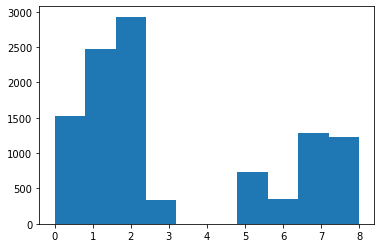

In [45]:
#Plotting the Malware distribution for Test Dataset (All 10K files)
plt.hist(Testo_Y_pred_label)

In [46]:
print(datetime.datetime.now())

2019-12-02 00:38:33.748126


### References:   
[1] Raff, E., Barker, J., Sylvester, J., Brandon, R., Catanzaro, B., & Nicholas, C.K. (2017). Malware Detection by Eating a Whole EXE. ArXiv, abs/1710.09435.   
[2] Dataset: https://www.kaggle.com/c/malware-classification/data  
[3] Keras Functional API: https://keras.io/models/model/  
[4] Keras Layers: https://keras.io/layers/about-keras-layers/  
[5] Binascii: https://docs.python.org/3/library/binascii.html  
[6] Sample MalConv: https://github.com/j40903272/MalConv-keras  